### Import the necessary libraries

In [132]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import layers, models
import requests

### Loading the data

In [133]:
# load the data
df = pd.read_pickle('data/words_df_all.pkl.gz')

In [134]:
df.head()

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
0,a01-000u-00-00,ok,154,"(408, 768, 27, 51)",AT,A,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,a01-000u-00-01,ok,154,"(507, 766, 213, 48)",NN,MOVE,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,a01-000u-00-02,ok,154,"(796, 764, 70, 50)",TO,to,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,a01-000u-00-03,ok,154,"(919, 757, 166, 78)",VB,stop,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,a01-000u-00-04,ok,154,"(1185, 754, 126, 61)",NPT,Mr.,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [135]:
print(df.shape)

(115319, 7)


### Splitting train, validation, and test data

In [136]:
for i, img in enumerate(df['ImageData']):
    if type(img) != np.ndarray:
        print(df['WordID'][i])
        # delete the current row from df
        df.drop(i, inplace=True)

a01-117-05-02
r06-022-03-04


In [137]:
# print the row in which imagdate is none
df[df['ImageData'].isnull()]

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
113621,r06-022-03-05,ok,184,"(924, 1304, 132, 29)",QL,more,None


In [138]:
df = df[df['ImageData'].notnull()]

In [139]:
print(df['ImageData'].apply(type).value_counts())

ImageData
<class 'numpy.ndarray'>    115316
Name: count, dtype: int64


In [140]:
print(len(df['Transcription'].unique()))

13549


In [141]:
# calculate the longest word
max_len = 0
for word in df['Transcription']:
    if len(word) > max_len:
        max_len = len(word)
print(max_len)

21


In [158]:
# shuffle and select only 10% of the dataframe and save it to df_small
df = df.sample(frac=1).reset_index(drop=True)
df_small = df[:int(len(df) * 0.1)]

# Split data into training and validation sets
X = np.stack(df_small['ImageData'].values)  # Convert the list of images to a numpy array
y = df_small['Transcription'].values

In [159]:
# print the top 40 value counts of the array y
print(pd.Series(y).value_counts()[:10])

the    561
,      558
.      541
of     314
to     287
and    247
a      227
in     200
"      159
was    120
Name: count, dtype: int64


In [160]:
def encode_to_labels(y):
    # create a list of the chartcaters vocabulary ordered alphabetically
    vocabulary = sorted(set(''.join(y)))

    # create a dictionary mapping each character to the vocabulary list index. do not use 0.
    char_to_num = {char:idx+1 for idx, char in enumerate(vocabulary)}

    # transform y values to numerical using the char_to_num dictionary, using 0 for padding. the length of each word is the maximum length of the words in the dataset
    y_encoded = []
    for word in y:
        word_encoded = [char_to_num[char] for char in word]
        y_encoded.append(word_encoded)

    # pad the encoded values (fill with 0s to the right)
    y_encoded = tf.keras.preprocessing.sequence.pad_sequences(y_encoded, padding='post')

    return y_encoded

y = encode_to_labels(y)

In [161]:
print(X.shape)
print(y.shape)

(11531, 32, 128, 1)
(11531, 19)


In [162]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(9224, 32, 128, 1)
(9224, 19)
(1153, 32, 128, 1)
(1153, 19)
(1154, 32, 128, 1)
(1154, 19)


and


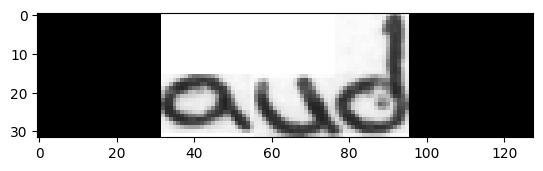

pretend


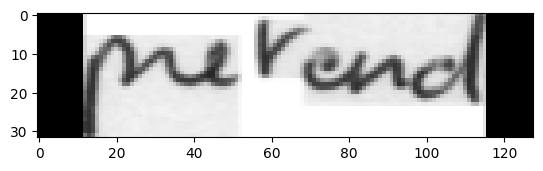

and


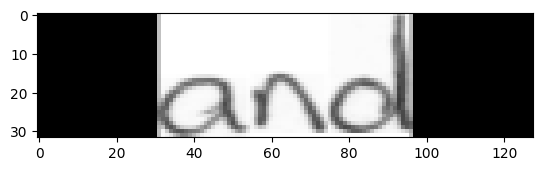

duke's


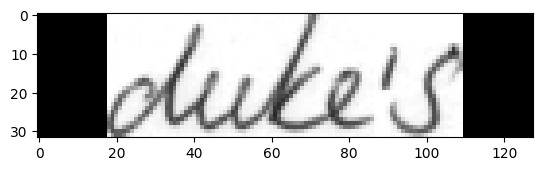

at


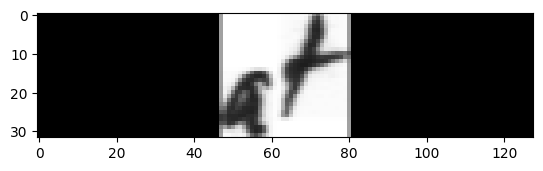

of


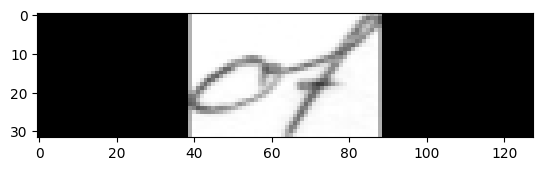

at


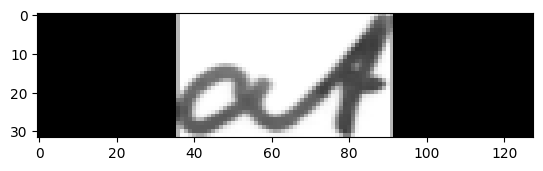

to


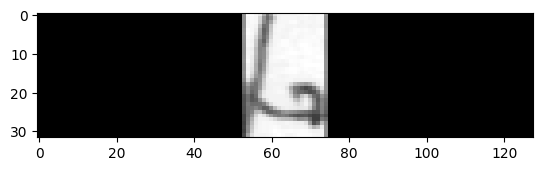

enough


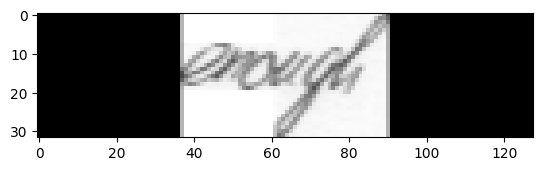

-


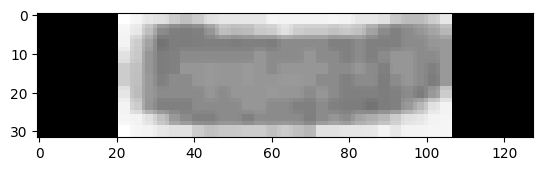

In [163]:
# display the first 10 images in the training set df['ImageData] with the corresponding transcription df['Transcription']
# use the dataframe 
# print one image per line

for i in range(10):
    print(df['Transcription'][i])
    plt.imshow(df['ImageData'][i][:,:,0], cmap='gray')
    plt.show()

In [164]:
# save value_counts of transcription of df to a df and export it to txt
df['Transcription'].value_counts().to_csv('data/transcription_value_counts_all.txt', header=None, sep=' ')

### Neural Networks

#### (Model 1) Starting simple

In [170]:
# Plotting the Training and Validation Loss and Accuracy
def plot_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Get training and test accuracy histories
    training_accuracy = history.history['accuracy']
    test_accuracy = history.history['val_accuracy']

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, test_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [167]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_improved_cnn(input_shape, output_length, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Add flatten layer
    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # Output layer with 'num_classes' units
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    
    return model

# Define your parameters
input_shape = X_train.shape[1:]  # Replace with actual shape (32, 128, 1)
output_length = y_train.shape[1]  # Replace with actual length 18
num_classes = y_train.shape[1]  # Replace with the actual number of classes

# Create and compile the improved model
model = create_improved_cnn(input_shape, output_length, num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

plot_history(history)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 16, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 16, 64, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 8, 32, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 8, 32, 128)        73856     
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 4, 16, 128)      

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 32, 128, 32)       320       
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 16, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 16, 64, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 8, 32, 64)         0         
 ng2D)                                                           
                                                                 
 reshape_6 (Reshape)         (None, 32, 512)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 32, 256)         

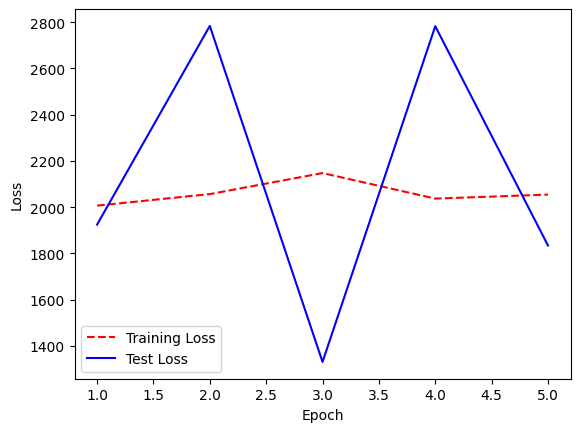

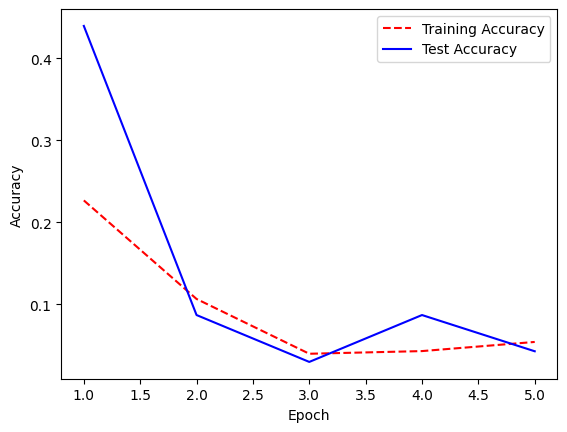

In [174]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_rnn(input_shape, output_length, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Prepare for the RNN layer
    model.add(layers.Reshape(target_shape=(-1, 64 * (input_shape[0] // 4))))  # Adjust depending on your input shape

    # RNN Layer - LSTM
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(64)))

    # Dense Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Output layer without activation
    model.add(layers.Dense(num_classes))

    
    return model

# Define your parameters
input_shape = X_train.shape[1:]  # Replace with actual shape (32, 128, 1)
output_length = y_train.shape[1]  # Replace with actual length 18
num_classes = y_train.shape[1] # Replace with the actual number of classes

# Create and compile the CNN-RNN model
model = create_cnn_rnn(input_shape, output_length, num_classes)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

plot_history(history)

#### (Model 2) Adding Embedding layer

In [177]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model_with_embedding(input_shape, output_length, num_classes):
    # Image model
    image_input = tf.keras.Input(shape=input_shape, name='image_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Label input for embedding
    label_input = tf.keras.Input(shape=(output_length,), name='label_input')
    label_embedding = layers.Embedding(input_dim=num_classes, output_dim=50)(label_input)
    
    # Combine image features with label embeddings
    combined = layers.concatenate([x, layers.Flatten()(label_embedding)])
    
    # Add a dense layer
    combined = layers.Dense(128, activation='relu')(combined)
    
    # Output layer
    output = layers.Dense(num_classes, activation='sigmoid')(combined)

    # Create model
    model = models.Model(inputs=[image_input, label_input], outputs=output)

    return model

# Define your parameters
input_shape = (32, 128, 1) 
output_length = 18
num_classes = 21

# Create and compile the model
model = create_model_with_embedding(input_shape, output_length, num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

plot_history(history)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 32, 128, 32)          320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_75 (MaxPooli  (None, 16, 64, 32)           0         ['conv2d_76[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_77 (Conv2D)          (None, 16, 64, 64)           18496     ['max_pooling2d_75[0][0]

ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_8" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 32, 128, 1) dtype=float32>]


In [196]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend

# Define a custom CTC layer
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

def create_model_with_ctc(input_shape, output_length, num_classes):
    # Image model
    image_input = tf.keras.Input(shape=input_shape, name='image_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Reshape(target_shape=(-1, 64 * (input_shape[0] // 4)))(x)  # Prepare for RNN

    # RNN layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # Output layer for CTC
    x = layers.Dense(num_classes + 1, activation='softmax')(x)
    # Output layer for CTC
    # x = layers.Dense(num_classes + 1, activation='log_softmax')(x) # Use log softmax instead of softmax

    # Labels input
    labels = layers.Input(name='labels', shape=(None,))

    # CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)
    
    # Define the model
    model = models.Model(inputs=[image_input, labels], outputs=output)

    # Compile the model
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt)

    return model

# Define your parameters
input_shape = (32, 128, 1)  # Replace with actual shape
output_length = 20  # Replace with actual length
num_classes = 21  # 21 actual classes + 1 for the CTC blank character

# Create and compile the model
model = create_model_with_ctc(input_shape, output_length, num_classes)

# Print summary
model.summary()


history = model.fit(
    [X_train, y_train],  # Provide image and label inputs
    y_train,  # True labels for the CTC loss
    epochs=5,
    validation_data=([X_val, y_val], y_val)  # Validation data
)

plot_history(history)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_100 (Conv2D)         (None, 32, 128, 32)          320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_99 (MaxPooli  (None, 16, 64, 32)           0         ['conv2d_100[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_101 (Conv2D)         (None, 16, 64, 64)           18496     ['max_pooling2d_99[0][0

2023-12-27 17:44:02.243962: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at ctc_loss_op.cc:216 : INVALID_ARGUMENT: Saw a non-null label (index >= num_classes - 1) following a null label, batch: 0 num_classes: 22 labels: 46,59,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 labels seen so far: 


InvalidArgumentError: Graph execution error:

Detected at node model_20/ctc_loss/CTCLoss defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_53581/760199384.py", line 68, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_53581/157963620.py", line 18, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 7169, in ctc_batch_cost

Saw a non-null label (index >= num_classes - 1) following a null label, batch: 0 num_classes: 22 labels: 46,59,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 labels seen so far: 
	 [[{{node model_20/ctc_loss/CTCLoss}}]] [Op:__inference_train_function_332635]